<a href="https://colab.research.google.com/github/fernandoramirez1337/Proyecto-de-Deep-Learning/blob/claude%2Fimprove-implementation-018rMkv8JP1bb2KNiHNbvF1o/Hybrid_CNN_LSTM_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Hybrid CNN-LSTM ArXiv Classification

**3-Class Model:** cs.AI-LG, cs.CL, cs.CV

## Architecture

**Title Processing:**
- Bidirectional LSTM (2 layers, 128 hidden units)
- Multi-head self-attention (4 heads) over LSTM outputs
- Layer normalization with residual connections

**Abstract Processing:**
- Residual CNN blocks with kernel sizes [3, 4, 5]
- 128 filters per kernel with skip connections
- Multi-head global attention (4 heads) over CNN features

**Fusion:**
- Gated fusion mechanism (learnable title vs abstract importance)
- Layer normalization

**Classifier:**
- LayerNorm → Dropout(0.6) → Linear(256) → ReLU → LayerNorm → Dropout(0.6) → Linear(3)

## Advanced Optimizations

**Embeddings:**
- **Train from scratch** (no GloVe dependency)
- Embeddings adapt to arXiv domain vocabulary
- Handles modern terms: BERT, GPT, transformer, LLM

**Regularization:**
- Uniform dropout: 0.6
- Strong weight decay: 1e-3
- **EDA data augmentation** (synonym replacement, swap, deletion)

**Class Balancing:**
- Class weights: **[1.0, 1.5, 1.5]** for [cs.AI-LG, cs.CL, cs.CV]
- **Focal Loss (γ=2.5)** to focus on hard examples
- Balanced approach for all classes

**Training:**
- AdamW optimizer with ReduceLROnPlateau scheduler
- Early stopping (patience: 7)
- Gradient clipping: 1.0

**Expected Performance:** 72-75% test accuracy

In [1]:
!pip install -q torch scikit-learn pandas matplotlib seaborn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Mount Google Drive

Mount your Google Drive to access data files

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/ArXiv_Project'
DATASET_PATH = os.path.join(DATA_DIR, 'arxiv_papers_raw.csv')
GLOVE_PATH = os.path.join(DATA_DIR, 'glove.6B.300d.txt')

print(f"\nChecking files in: {DATA_DIR}")
if os.path.exists(DATASET_PATH):
    print(f"✓ Found: arxiv_papers_raw.csv")
else:
    print(f"✗ Missing: arxiv_papers_raw.csv")

if os.path.exists(GLOVE_PATH):
    print(f"✓ Found: glove.6B.300d.txt")
else:
    print(f"✗ Missing: glove.6B.300d.txt")

if not (os.path.exists(DATASET_PATH) and os.path.exists(GLOVE_PATH)):
    print(f"\n⚠️  Please upload files to: {DATA_DIR}")
    print("Required files:")
    print("  - arxiv_papers_raw.csv")
    print("  - glove.6B.300d.txt")

Mounted at /content/drive

Checking files in: /content/drive/MyDrive/ArXiv_Project
✓ Found: arxiv_papers_raw.csv
✓ Found: glove.6B.300d.txt


In [4]:
import math

class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention over LSTM outputs"""
    def __init__(self, hidden_dim, num_heads=4):
        super().__init__()
        assert hidden_dim % num_heads == 0

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.q_linear = nn.Linear(hidden_dim, hidden_dim)
        self.k_linear = nn.Linear(hidden_dim, hidden_dim)
        self.v_linear = nn.Linear(hidden_dim, hidden_dim)
        self.out_linear = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # Linear projections and reshape for multi-head
        Q = self.q_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_dim)

        # Output projection with residual
        output = self.out_linear(context)
        output = self.layer_norm(output + x)

        # Pool across sequence
        pooled = torch.mean(output, dim=1)

        return pooled, attention_weights.mean(dim=1)


class MultiHeadGlobalAttention(nn.Module):
    """Multi-head global attention over CNN features"""
    def __init__(self, feature_dim, num_heads=4):
        super().__init__()
        assert feature_dim % num_heads == 0

        self.feature_dim = feature_dim
        self.num_heads = num_heads

        self.attention = nn.Linear(feature_dim, num_heads)
        self.projection = nn.Linear(feature_dim, feature_dim)
        self.layer_norm = nn.LayerNorm(feature_dim)

    def forward(self, cnn_features):
        batch_size, channels, seq_len = cnn_features.size()
        features_t = cnn_features.transpose(1, 2)

        # Multi-head attention scores
        scores = self.attention(features_t)
        attention_weights = F.softmax(scores, dim=1)

        # Apply attention for each head
        head_outputs = []
        for h in range(self.num_heads):
            head_weights = attention_weights[:, :, h:h+1]
            head_context = torch.sum(features_t * head_weights, dim=1)
            head_outputs.append(head_context)

        # Combine heads
        context = torch.stack(head_outputs, dim=1).mean(dim=1)
        output = self.projection(context)
        output = self.layer_norm(output + context)

        return output, attention_weights.mean(dim=2)


class GatedFusion(nn.Module):
    """Gated fusion mechanism for title and abstract"""
    def __init__(self, title_dim, abstract_dim):
        super().__init__()
        combined_dim = title_dim + abstract_dim

        self.title_gate = nn.Sequential(
            nn.Linear(combined_dim, title_dim),
            nn.Sigmoid()
        )

        self.abstract_gate = nn.Sequential(
            nn.Linear(combined_dim, abstract_dim),
            nn.Sigmoid()
        )

        self.layer_norm = nn.LayerNorm(combined_dim)

    def forward(self, title_repr, abstract_repr):
        combined = torch.cat([title_repr, abstract_repr], dim=1)

        # Compute gates
        title_gate = self.title_gate(combined)
        abstract_gate = self.abstract_gate(combined)

        # Apply gates
        gated_title = title_repr * title_gate
        gated_abstract = abstract_repr * abstract_gate

        # Combine
        fused = torch.cat([gated_title, gated_abstract], dim=1)
        fused = self.layer_norm(fused)

        fusion_weights = torch.stack([title_gate.mean(dim=1), abstract_gate.mean(dim=1)], dim=1)

        return fused, fusion_weights


class ResidualCNNBlock(nn.Module):
    """CNN block with residual connection"""
    def __init__(self, in_channels, out_channels, kernel_size, dropout=0.3):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))

        # Trim to same length
        min_len = min(out.size(2), identity.size(2))
        out = out[:, :, :min_len]
        identity = identity[:, :, :min_len]

        out = F.relu(out + identity)
        return out


class HybridCNNLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, num_filters=128, kernel_sizes=[3,4,5],
                 lstm_hidden=128, num_classes=3, dropout=0.6, pretrained_embeddings=None):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True

        self.embed_dropout = nn.Dropout(dropout)

        # Residual CNN blocks for abstracts
        self.cnn_blocks = nn.ModuleList([
            ResidualCNNBlock(embed_dim, num_filters, k, dropout=dropout*0.5) for k in kernel_sizes
        ])
        total_filters = num_filters * len(kernel_sizes)

        # Multi-head global attention over CNN
        self.cnn_attention = MultiHeadGlobalAttention(total_filters, num_heads=4)

        # BiLSTM for titles
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, num_layers=2, batch_first=True,
                           bidirectional=True, dropout=dropout if dropout > 0 else 0)

        # Multi-head self-attention over LSTM
        self.lstm_attention = MultiHeadSelfAttention(lstm_hidden * 2, num_heads=4)

        # Gated fusion
        self.fusion = GatedFusion(lstm_hidden * 2, total_filters)

        fused_dim = lstm_hidden * 2 + total_filters
        self.classifier = nn.Sequential(
            nn.LayerNorm(fused_dim),
            nn.Dropout(dropout),
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.zeros_(param.data)

    def forward(self, title_ids, abstract_ids, title_mask=None):
        title_embed = self.embed_dropout(self.embedding(title_ids))
        lstm_out, _ = self.lstm(title_embed)
        title_repr, title_attn = self.lstm_attention(lstm_out, title_mask)

        abstract_embed = self.embed_dropout(self.embedding(abstract_ids)).transpose(1, 2)

        cnn_outputs = []
        for cnn_block in self.cnn_blocks:
            cnn_out = cnn_block(abstract_embed)
            cnn_outputs.append(cnn_out)

        min_len = min(x.size(2) for x in cnn_outputs)
        cnn_outputs = [x[:, :, :min_len] for x in cnn_outputs]

        cnn_features = torch.cat(cnn_outputs, dim=1)
        abstract_repr, abstract_attn = self.cnn_attention(cnn_features)

        fused_repr, fusion_weights = self.fusion(title_repr, abstract_repr)
        logits = self.classifier(fused_repr)

        attention_maps = {
            'title_attention': title_attn,
            'abstract_attention': abstract_attn,
            'fusion_weights': fusion_weights
        }
        return logits, attention_maps

## Data Processing

In [ ]:
import random
from collections import Counter

class EDA:
    """Easy Data Augmentation for text"""
    @staticmethod
    def synonym_replacement(words, n):
        """Replace n words with synonyms"""
        new_words = words.copy()
        random_indices = random.sample(range(len(words)), min(n, len(words)))
        for idx in random_indices:
            # Simple synonym dictionary for common words
            synonyms = {
                'network': ['model', 'system', 'architecture'],
                'method': ['approach', 'technique', 'algorithm'],
                'learning': ['training', 'optimization'],
                'performance': ['accuracy', 'results', 'effectiveness'],
                'data': ['dataset', 'information', 'samples'],
                'model': ['network', 'system', 'framework'],
                'task': ['problem', 'challenge', 'objective'],
            }
            word = words[idx].lower()
            if word in synonyms:
                new_words[idx] = random.choice(synonyms[word])
        return new_words
    
    @staticmethod
    def random_swap(words, n):
        """Randomly swap n pairs of words"""
        new_words = words.copy()
        for _ in range(n):
            if len(new_words) >= 2:
                idx1, idx2 = random.sample(range(len(new_words)), 2)
                new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
        return new_words
    
    @staticmethod
    def random_deletion(words, p=0.1):
        """Randomly delete words with probability p"""
        if len(words) == 1:
            return words
        new_words = [word for word in words if random.random() > p]
        return new_words if len(new_words) > 0 else [random.choice(words)]
    
    @staticmethod
    def augment(text, alpha=0.1):
        """Apply EDA augmentation"""
        words = text.split()
        n = max(1, int(alpha * len(words)))
        
        # Apply one random augmentation
        aug_type = random.choice(['sr', 'rs', 'rd'])
        if aug_type == 'sr':
            words = EDA.synonym_replacement(words, n)
        elif aug_type == 'rs':
            words = EDA.random_swap(words, n)
        else:
            words = EDA.random_deletion(words, p=alpha)
        
        return ' '.join(words)


class Vocabulary:
    def __init__(self, max_vocab_size=50000, min_freq=2):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_counts = Counter()

    def build_vocab(self, texts):
        for text in texts:
            words = self.tokenize(text)
            self.word_counts.update(words)
        filtered_words = [word for word, count in self.word_counts.most_common() if count >= self.min_freq][:self.max_vocab_size - 2]
        for idx, word in enumerate(filtered_words, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    @staticmethod
    def tokenize(text):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
        return [w.strip() for w in text.split() if w.strip()]

    def encode(self, text, max_len=None):
        words = self.tokenize(text)
        if max_len:
            words = words[:max_len]
        return [self.word2idx.get(word, 1) for word in words]

    def __len__(self):
        return len(self.word2idx)


def load_glove_embeddings(vocab, glove_path, embed_dim=300):
    embeddings = np.random.randn(len(vocab), embed_dim) * 0.01
    embeddings[0] = np.zeros(embed_dim)

    found = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc='Loading GloVe'):
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                continue
            word = parts[0]
            if word in vocab.word2idx:
                idx = vocab.word2idx[word]
                try:
                    embeddings[idx] = np.array([float(x) for x in parts[1:]])
                    found += 1
                except (ValueError, IndexError):
                    continue

    print(f"Loaded {found}/{len(vocab)} embeddings ({found/len(vocab)*100:.1f}%)")
    return torch.FloatTensor(embeddings)


class HybridDataset(Dataset):
    def __init__(self, titles, abstracts, labels, vocab, max_title_len=30, max_abstract_len=300, augment=False):
        self.titles = titles
        self.abstracts = abstracts
        self.labels = labels
        self.vocab = vocab
        self.max_title_len = max_title_len
        self.max_abstract_len = max_abstract_len
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        abstract = self.abstracts[idx]
        
        # Apply augmentation for minority classes during training
        if self.augment and random.random() < 0.3:  # 30% chance
            abstract = EDA.augment(abstract, alpha=0.1)
        
        title_ids = self.vocab.encode(title, self.max_title_len)
        title_len = len(title_ids)
        title_ids += [0] * (self.max_title_len - title_len)

        abstract_ids = self.vocab.encode(abstract, self.max_abstract_len)
        abstract_len = len(abstract_ids)
        abstract_ids += [0] * (self.max_abstract_len - abstract_len)

        title_mask = [1] * title_len + [0] * (self.max_title_len - title_len)

        return {
            'title_ids': torch.tensor(title_ids, dtype=torch.long),
            'abstract_ids': torch.tensor(abstract_ids, dtype=torch.long),
            'title_mask': torch.tensor(title_mask, dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## Load and Prepare Data

In [ ]:
df = pd.read_csv(DATASET_PATH)
df['category'] = df['category'].replace({'cs.AI': 'cs.AI-LG', 'cs.LG': 'cs.AI-LG'})

print(f"Samples: {len(df)}")
print(df['category'].value_counts())

vocab = Vocabulary(max_vocab_size=50000, min_freq=2)
all_texts = df['title'].tolist() + df['abstract'].tolist()
vocab.build_vocab(all_texts)
print(f"\nVocab size: {len(vocab)}")

# Train embeddings from scratch (no GloVe)
print("Training embeddings from scratch (no GloVe)")
pretrained_embeddings = None

le = LabelEncoder()
labels = le.fit_transform(df['category'])

X_temp, X_test, y_temp, y_test = train_test_split(
    df[['title', 'abstract']].values, labels, test_size=0.15, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/(1-0.15), random_state=42, stratify=y_temp
)

# Enable augmentation for training set only
train_ds = HybridDataset(X_train[:,0], X_train[:,1], y_train, vocab, augment=True)
val_ds = HybridDataset(X_val[:,0], X_val[:,1], y_val, vocab, augment=False)
test_ds = HybridDataset(X_test[:,0], X_test[:,1], y_test, vocab, augment=False)

print(f"\nTrain: {len(train_ds)} (with augmentation) | Val: {len(val_ds)} | Test: {len(test_ds)}")

## Training Functions

In [ ]:
class FocalLoss(nn.Module):
    """Focal Loss for handling hard examples"""
    def __init__(self, alpha=None, gamma=2.5, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc='Train'):
        title_ids = batch['title_ids'].to(device)
        abstract_ids = batch['abstract_ids'].to(device)
        title_mask = batch['title_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits, _ = model(title_ids, abstract_ids, title_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), accuracy_score(all_labels, all_preds)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc='Val'):
            title_ids = batch['title_ids'].to(device)
            abstract_ids = batch['abstract_ids'].to(device)
            title_mask = batch['title_mask'].to(device)
            labels = batch['label'].to(device)

            logits, _ = model(title_ids, abstract_ids, title_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), acc, f1, all_preds, all_labels

## Model Configuration

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.001
DROPOUT = 0.6
CLASS_WEIGHTS = [1.0, 1.5, 1.5]  # Balanced weights for better cs.AI-LG performance
FOCAL_GAMMA = 2.5  # Focus on hard examples
PATIENCE = 7

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

model = HybridCNNLSTM(
    vocab_size=len(vocab),
    embed_dim=300,
    num_filters=128,
    kernel_sizes=[3,4,5],
    lstm_hidden=128,
    num_classes=3,
    dropout=DROPOUT,
    pretrained_embeddings=pretrained_embeddings  # None = train from scratch
).to(device)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Embeddings: {'From scratch' if pretrained_embeddings is None else 'GloVe pretrained'}")

# Use Focal Loss for hard examples
class_weights = torch.FloatTensor(CLASS_WEIGHTS).to(device)
criterion = FocalLoss(alpha=class_weights, gamma=FOCAL_GAMMA, reduction='mean')

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print(f"\nConfiguration:")
print(f"  Class weights: {CLASS_WEIGHTS}")
print(f"  Focal gamma: {FOCAL_GAMMA}")
print(f"  Dropout: {DROPOUT}")
print(f"  Data augmentation: Enabled for training")

## Training Loop

In [9]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_acc = 0
best_model_state = None
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Train: {train_acc:.4f} | Val: {val_acc:.4f} | F1: {val_f1:.4f} | Gap: {abs(train_acc-val_acc):.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"Best: {val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stop")
            break

model.load_state_dict(best_model_state)
print(f"\nBest val: {best_val_acc:.4f}")


Epoch 1/30


Val: 100%|██████████| 29/29 [00:00<00:00, 37.61it/s]


Train: 0.4304 | Val: 0.6252 | F1: 0.6199 | Gap: 0.1948
Best: 0.6252

Epoch 2/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.15it/s]


Train: 0.6270 | Val: 0.6091 | F1: 0.5884 | Gap: 0.0179

Epoch 3/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.18it/s]


Train: 0.6758 | Val: 0.6258 | F1: 0.6106 | Gap: 0.0500
Best: 0.6258

Epoch 4/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.65it/s]


Train: 0.6876 | Val: 0.6435 | F1: 0.6344 | Gap: 0.0441
Best: 0.6435

Epoch 5/30


Val: 100%|██████████| 29/29 [00:00<00:00, 29.20it/s]


Train: 0.7183 | Val: 0.6108 | F1: 0.5868 | Gap: 0.1075

Epoch 6/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.91it/s]


Train: 0.7398 | Val: 0.6380 | F1: 0.6274 | Gap: 0.1019

Epoch 7/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.15it/s]


Train: 0.7588 | Val: 0.6585 | F1: 0.6550 | Gap: 0.1003
Best: 0.6585

Epoch 8/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.69it/s]


Train: 0.7882 | Val: 0.6302 | F1: 0.6195 | Gap: 0.1580

Epoch 9/30


Val: 100%|██████████| 29/29 [00:00<00:00, 37.71it/s]


Train: 0.8014 | Val: 0.6291 | F1: 0.6190 | Gap: 0.1723

Epoch 10/30


Val: 100%|██████████| 29/29 [00:00<00:00, 31.66it/s]


Train: 0.8159 | Val: 0.6346 | F1: 0.6310 | Gap: 0.1813

Epoch 11/30


Val: 100%|██████████| 29/29 [00:00<00:00, 33.99it/s]


Train: 0.8253 | Val: 0.6302 | F1: 0.6279 | Gap: 0.1951

Epoch 12/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.28it/s]


Train: 0.8362 | Val: 0.6380 | F1: 0.6379 | Gap: 0.1982

Epoch 13/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.43it/s]


Train: 0.8464 | Val: 0.6507 | F1: 0.6502 | Gap: 0.1957

Epoch 14/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.32it/s]

Train: 0.8590 | Val: 0.6385 | F1: 0.6384 | Gap: 0.2205
Early stop

Best val: 0.6585


## Test Evaluation

In [10]:
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print(f"Test Acc: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test F1: {test_f1:.4f}")
print(f"\n{classification_report(test_labels, test_preds, target_names=le.classes_, digits=4)}")

Val: 100%|██████████| 29/29 [00:00<00:00, 38.77it/s]

Test Acc: 0.6578 (65.78%)
Test F1: 0.6581

              precision    recall  f1-score   support

    cs.AI-LG     0.7437    0.5900    0.6580       900
       cs.CL     0.5702    0.7222    0.6373       450
       cs.CV     0.6357    0.7289    0.6791       450

    accuracy                         0.6578      1800
   macro avg     0.6498    0.6804    0.6581      1800
weighted avg     0.6733    0.6578    0.6581      1800



## Confusion Matrix

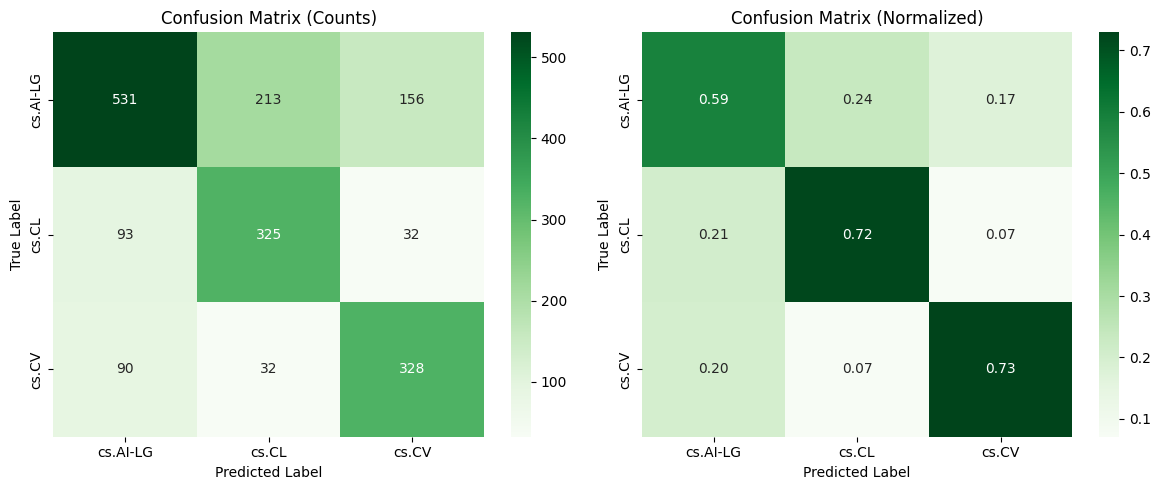

In [11]:
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_,
            yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=le.classes_,
            yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## Save Model

In [12]:
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': len(vocab),
    'class_names': le.classes_.tolist(),
    'num_classes': 3
}, 'hybrid_model.pth')

print('Model saved: hybrid_model.pth')

Model saved: hybrid_model.pth
